<img src="https://devra.ai/analyst/notebook/1532/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;"><div style="font-size:150%; color:#FEE100"><b>E-commerce Product Recommendation Analysis</b></div><div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>


# Introduction

It is fascinating to see how subtle product attributes such as pricing and customer review sentiment can drive recommendation probabilities. In this notebook, we explore a dataset that comprises product details and customer information from an e-commerce platform. We will perform detailed exploratory data analysis, and if our investigation deems it useful, build a predictive model for the probability of product recommendations. If you find this analysis engaging and useful, kindly upvote it.


# Table of Contents

1. [Data Loading](#Data-Loading)
2. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Prediction Model for Product Recommendation Probability](#Prediction-Model-for-Product-Recommendation-Probability)
5. [Summary and Conclusions](#Summary-and-Conclusions)


In [1]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

sns.set(style='whitegrid')


In [2]:
# Data Loading
# Load the product recommendation data
product_df = pd.read_csv('/kaggle/input/personalized-recommendations-for-e-commerce/product_recommendation_data.csv',
                         encoding='ascii', delimiter=',')

# Load the customer data collection
customer_df = pd.read_csv('/kaggle/input/personalized-recommendations-for-e-commerce/customer_data_collection.csv',
                          encoding='ascii', delimiter=',')

print('Product Data Shape:', product_df.shape)
print('Customer Data Shape:', customer_df.shape)

Product Data Shape: (10000, 15)
Customer Data Shape: (10000, 11)


In [3]:
# Data Cleaning and Preprocessing
## For Product Data

# Drop unnecessary unnamed columns if they exist
columns_to_drop = [col for col in product_df.columns if 'Unnamed' in col]
if columns_to_drop:
    product_df.drop(columns=columns_to_drop, inplace=True)

# View datatypes and check for any type issues
print('Product Data Types:')
print(product_df.dtypes)

# There are no explicit date columns, but Holiday and Season could be considered categorical

## For Customer Data

# Drop any unnecessary unnamed columns
columns_to_drop_cust = [col for col in customer_df.columns if 'Unnamed' in col]
if columns_to_drop_cust:
    customer_df.drop(columns=columns_to_drop_cust, inplace=True)

print('\nCustomer Data Types:')
print(customer_df.dtypes)

# In case there are missing values, one common practice is to fill or drop them.
# For demonstration, we simply print the missing value counts.
print('\nMissing values in Product Data:')
print(product_df.isnull().sum())

print('\nMissing values in Customer Data:')
print(customer_df.isnull().sum())

Product Data Types:
Product_ID                             object
Category                               object
Subcategory                            object
Price                                   int64
Brand                                  object
Average_Rating_of_Similar_Products    float64
Product_Rating                        float64
Customer_Review_Sentiment_Score       float64
Holiday                                object
Season                                 object
Geographical_Location                  object
Similar_Product_List                   object
Probability_of_Recommendation         float64
dtype: object

Customer Data Types:
Customer_ID          object
Age                   int64
Gender               object
Location             object
Browsing_History     object
Purchase_History     object
Customer_Segment     object
Avg_Order_Value     float64
Holiday              object
Season               object
dtype: object

Missing values in Product Data:
Product_ID         

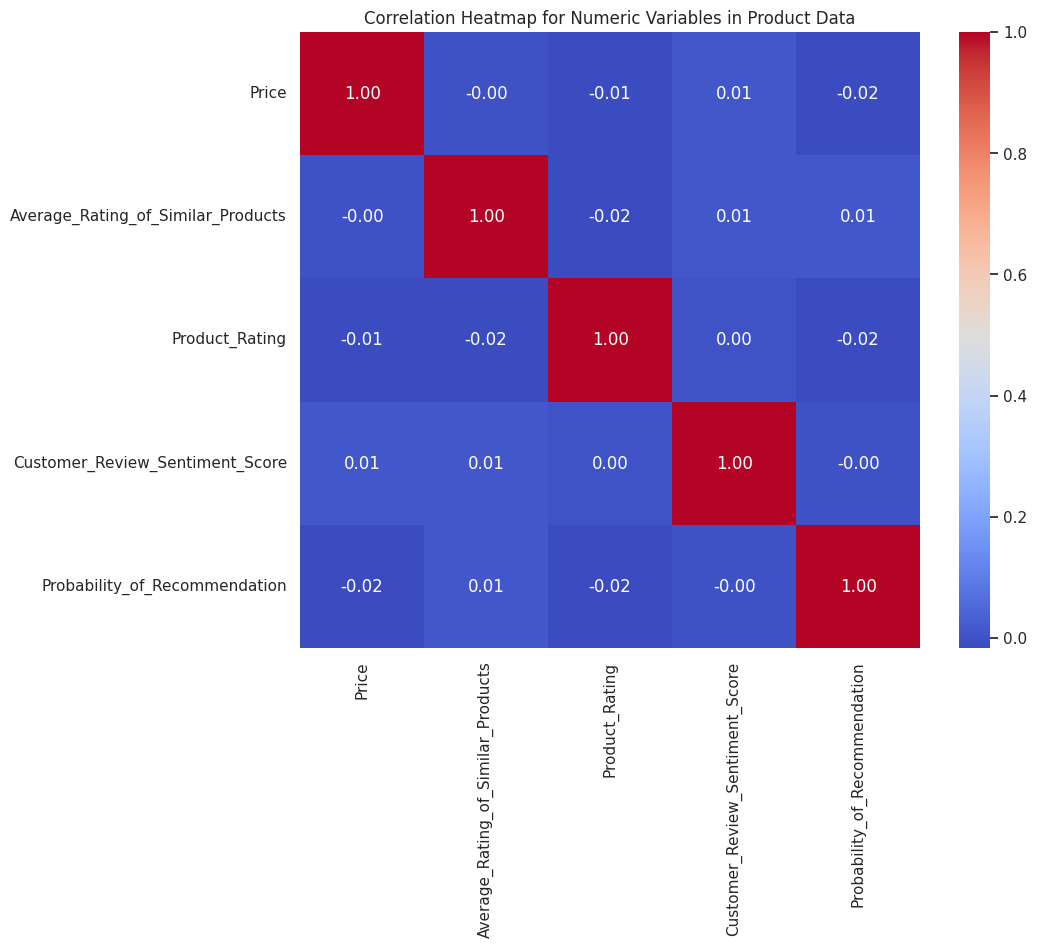

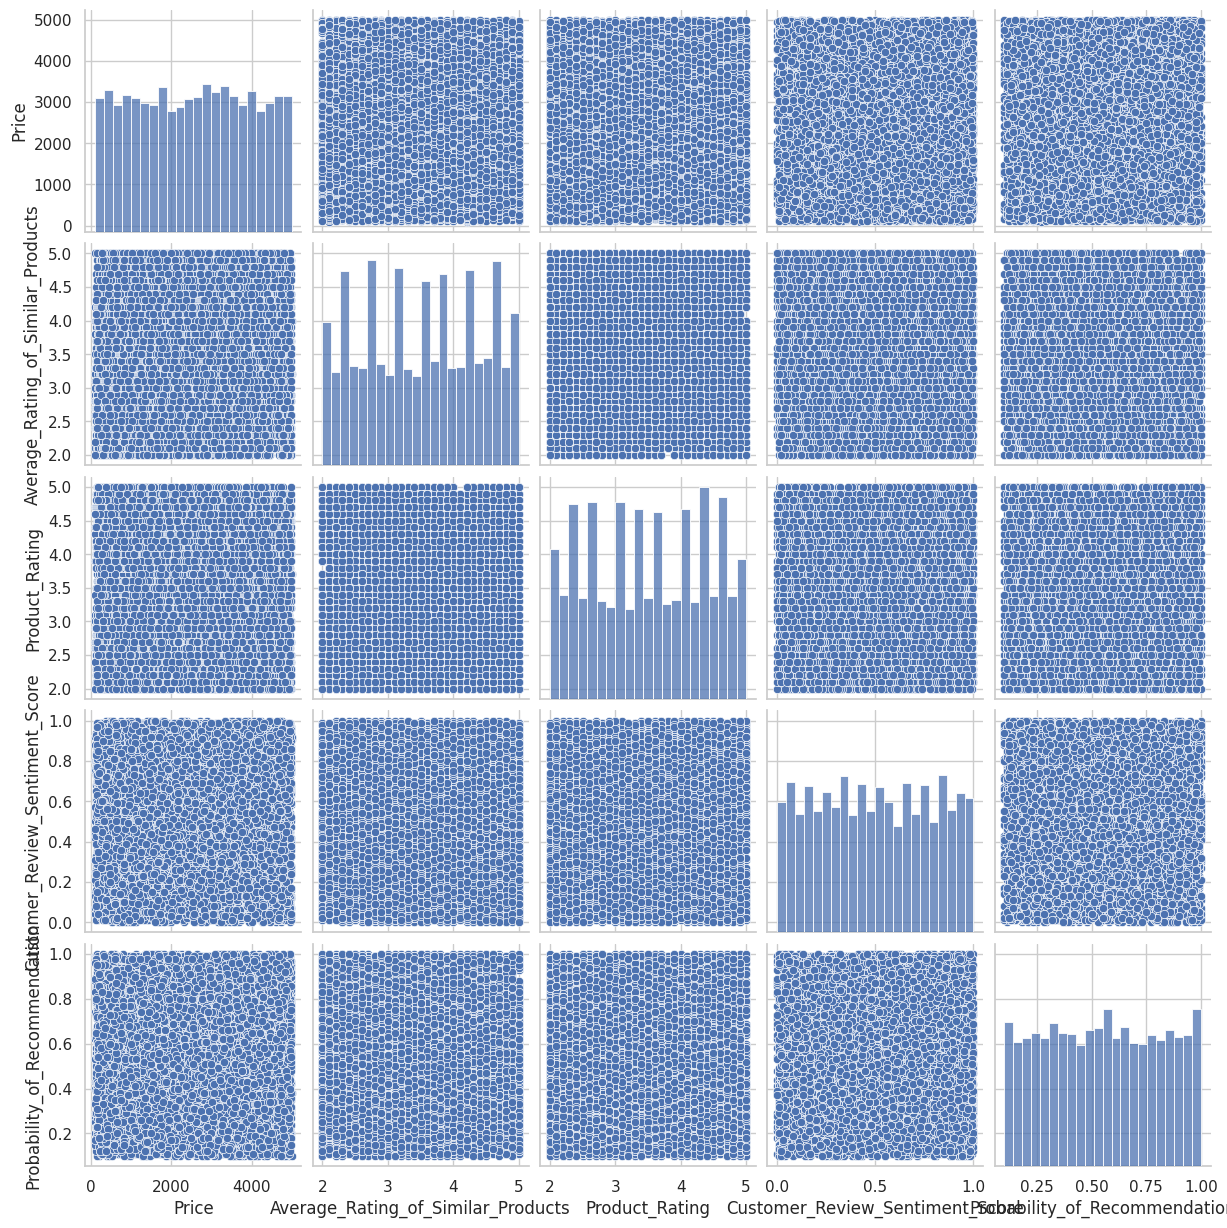

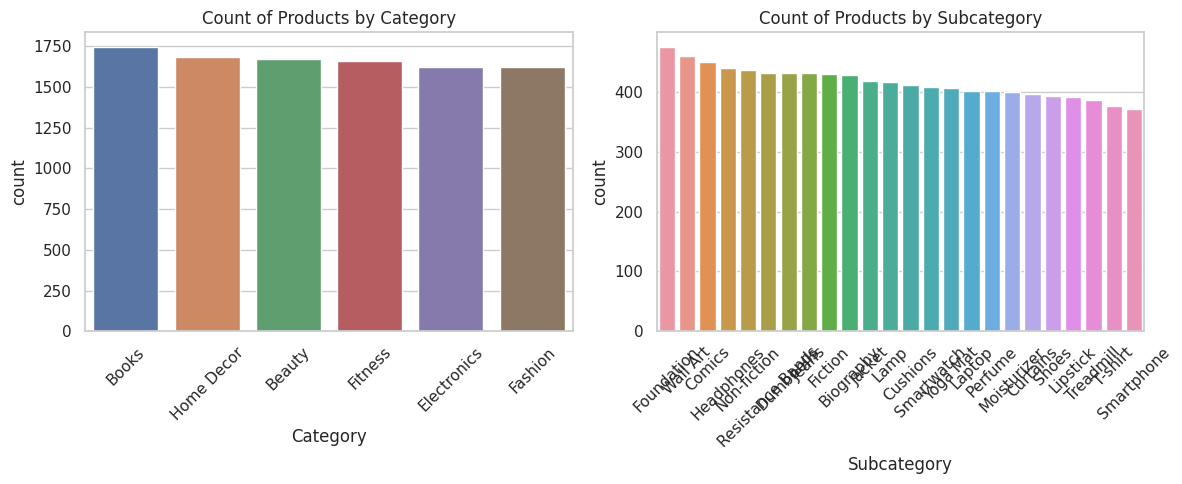

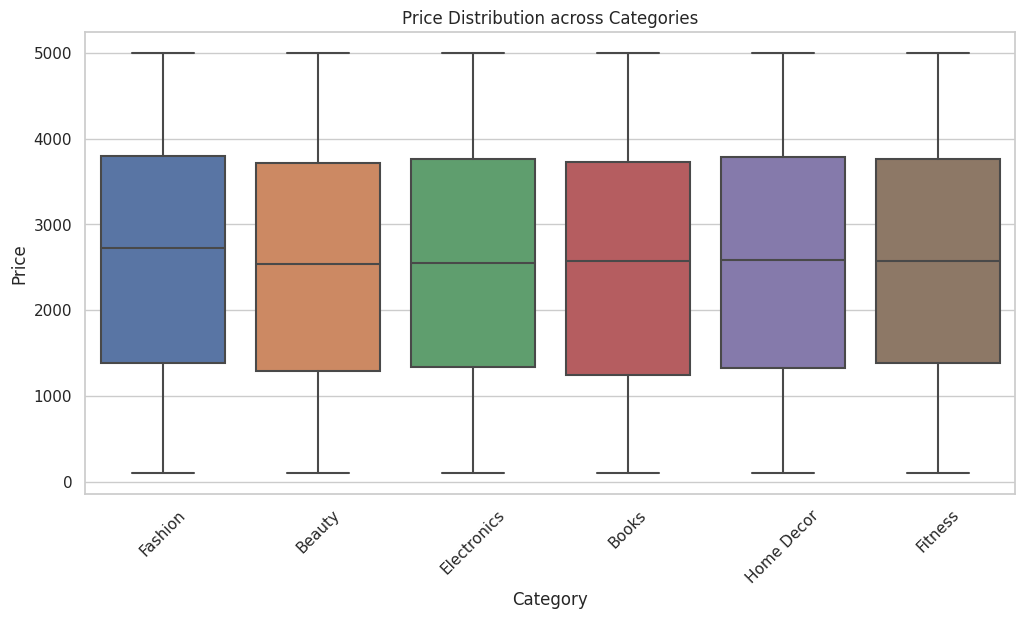

In [4]:
# Exploratory Data Analysis
## Correlation heatmap for numeric features in product data

# Select numeric columns from the product dataframe
numeric_df = product_df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Variables in Product Data')
    plt.show()
else:
    print('Not enough numeric columns to create a correlation heatmap.')

## Pair Plot for numeric variables to check relationships
sns.pairplot(numeric_df)
plt.show()

## Categorical plots: Count plot for Category and Subcategory
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=product_df, x='Category', order=product_df['Category'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Count of Products by Category')

plt.subplot(1, 2, 2)
sns.countplot(data=product_df, x='Subcategory', order=product_df['Subcategory'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Count of Products by Subcategory')

plt.tight_layout()
plt.show()

## Box plot for Price across Categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=product_df, x='Category', y='Price')
plt.xticks(rotation=45)
plt.title('Price Distribution across Categories')
plt.show()

Model Evaluation:
R2 Score: -0.0769133733188041
Mean Squared Error: 0.0724179336


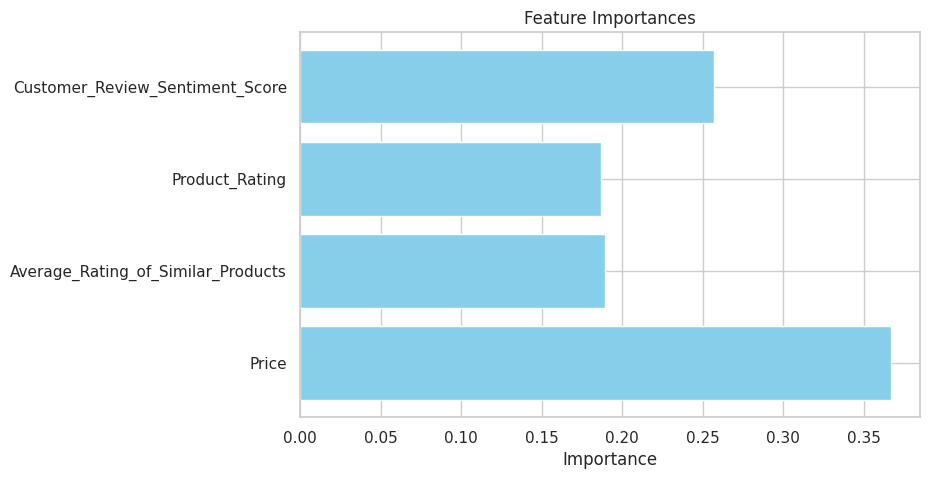

In [5]:
# Prediction Model for Product Recommendation Probability
## In this section, we attempt to predict the Probability_of_Recommendation for a product
## using selected numeric features. We are using a RandomForestRegressor and evaluating performance using R2 score and Mean Squared Error.

# Check if the target column exists
if 'Probability_of_Recommendation' in product_df.columns:
    # Select features. We take only numeric features that can logically help predict the probability.
    features = ['Price', 'Average_Rating_of_Similar_Products', 'Product_Rating', 'Customer_Review_Sentiment_Score']
    
    # Check if all features exist in the dataset
    available_features = [feat for feat in features if feat in product_df.columns]
    
    if len(available_features) < len(features):
        print('Some features are missing. Using only available features:', available_features)
        features = available_features
    
    # Prepare the data
    X = product_df[features].copy()
    y = product_df['Probability_of_Recommendation']
    
    # In case of missing values, we fill them with the median value
    X.fillna(X.median(), inplace=True)
    y.fillna(y.median(), inplace=True)
    
    # Split into train and test sets for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print('Model Evaluation:')
    print('R2 Score:', r2)
    print('Mean Squared Error:', mse)
    
    # Feature importances are insightful - plot permutation importance (simple barh plot)
    importances = model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.barh(features, importances, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
else:
    print('Target column Probability_of_Recommendation not found in product data.')
    
# Note: When developing predictive models, encountering missing values or unexpected data types is common.
# The methods used here to fill missing values (using median imputation) are widely applicable and help avoid potential errors.

# Summary and Conclusions

In this notebook, we loaded two datasets related to e-commerce product recommendations and customer data. We performed a thorough data cleaning and preprocessing phase, followed by exploratory data analysis using various visualizations such as heatmaps, pair plots, box plots, and count plots. We then built a regression model to predict the probability of product recommendation using features like Price, Average Rating of Similar Products, Product Rating, and Customer Review Sentiment Score.

The model evaluation using the R2 score and Mean Squared Error provides baseline insights into its performance. Future analysis could explore hyperparameter tuning, the inclusion of more features, and or even different modeling approaches such as gradient boosting machines. Additionally, integrating the customer data can lead to more personalized predictive insights.

Thank you for following along with this analysis. If you found it helpful, please consider upvoting the notebook.